In [60]:
# !pip3 install missingpy

In [1]:
# !pip3 install scikit-learn==0.20.1  # dep for missingpy
# !pip3 install scikit-learn==0.24.1  # required for getting tree diagram

  Using cached scikit_learn-0.24.1-cp37-cp37m-macosx_10_13_x86_64.whl (7.2 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.1
    Uninstalling scikit-learn-0.22.1:
      Successfully uninstalled scikit-learn-0.22.1
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.7/bin/python3.7 -m pip install --upgrade pip' command.


In [1]:
data_path = '../data/'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io.arff import loadarff
from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
random_state = 2021

## Year $N$

In [4]:
N = '1'
drop_cols = ['Attr37','Attr21']

In [5]:
arff = loadarff(data_path+N+'year.arff')
df = pd.DataFrame(arff[0])
df['class']= df['class'].astype('int')
df.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0


In [6]:
df.isnull().sum().sort_values(ascending=False).head()

Attr37    2740
Attr21    1622
Attr27     311
Attr60     135
Attr45     134
dtype: int64

In [7]:
df = df.drop(drop_cols,axis='columns')
df.shape

(7027, 63)

In [8]:
df = df.drop_duplicates()
df.shape

(6945, 63)

### Split train-dev-test without NaN in dev/test

In [37]:
na_free = df.dropna()
only_na = df[~df.index.isin(na_free.index)]

assert na_free.shape[0]+only_na.shape[0] == df.shape[0]

na_free.shape, only_na.shape

((6243, 63), (702, 63))

In [39]:
X = na_free.drop('class',axis='columns')
Y = na_free['class']
(X.shape,Y.shape)

((6243, 62), (6243,))

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.4, random_state=random_state,shuffle=True,stratify=Y)

In [41]:
X_train.shape,Y_train.shape

((3745, 62), (3745,))

In [42]:
X_train = pd.concat([X_train,only_na.drop('class',axis='columns')])
Y_train = pd.concat([Y_train,only_na['class']])
X_train.shape

(4447, 62)

In [43]:
X_val,X_test,Y_val,Y_test = train_test_split(
    X_test, Y_test, test_size=0.5, random_state=random_state, shuffle=True, stratify=Y_test)

In [44]:
X_val.shape,Y_val.shape,X_test.shape,Y_test.shape

((1249, 62), (1249,), (1249, 62), (1249,))

In [45]:
# % 1s in splitted dataset
Y_train.value_counts(), Y_val.value_counts(), Y_test.value_counts()

(0    4218
 1     229
 Name: class, dtype: int64,
 0    1228
 1      21
 Name: class, dtype: int64,
 0    1228
 1      21
 Name: class, dtype: int64)

### Retain NaN in test set also

In [9]:
X = df.drop('class',axis='columns')
Y = df['class']
(X.shape,Y.shape)

((6945, 62), (6945,))

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.25, random_state=random_state,shuffle=True,stratify=Y)

In [11]:
# % 1s in splitted dataset
Y_train.value_counts(), Y_test.value_counts()

(0    5005
 1     203
 Name: class, dtype: int64,
 0    1669
 1      68
 Name: class, dtype: int64)

In [12]:
X_train,Y_train,X_test,Y_test = X_train.to_numpy(),Y_train.to_numpy(),X_test.to_numpy(),Y_test.to_numpy()

## Missing values

In [13]:
def build_imputer(imputer_estimator,X_train,Y_train,transform_x=True,reset_index = True,verbose=True,max_iter=10,tol=1,imputer=None):
    # train = pd.concat([X_train,Y_train],axis=1)
    # train['class'] = train['class'].astype('category')
    # if reset_index:
    #     train = train.reset_index(drop=True)
    
    if imputer is None:
        imputer = IterativeImputer(estimator=imputer_estimator, n_nearest_features=None, imputation_order='ascending',verbose=verbose,max_iter=max_iter,tol=tol)
        imputer = imputer.fit(X_train,Y_train)
    else:
        imputer = imputer.fit(X_train,Y_train)
    
    if transform_x:
        train = imputer.transform(X_train)
        return imputer,train
    
    return imputer


In [14]:
def make_imputation(imputer,X_test):
    return imputer.transform(X_test)

In [59]:
from missingpy import MissForest

imputer = MissForest(random_state=2021,verbose=1,n_jobs=4)
imputer,X_train_imp = build_imputer(None,X_train,Y_train,transform_x=True,reset_index = True,verbose=True,imputer=imputer)
# X_imputed = imputer.fit_transform(X_train)

ModuleNotFoundError: No module named 'sklearn.neighbors.base'

In [66]:
# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


imputer_estimator=ExtraTreesRegressor(n_estimators=16, n_jobs=4, random_state=random_state, verbose=1)
imputer,X_train_imp = build_imputer(imputer_estimator,X_train,Y_train,transform_x=True,reset_index = True,verbose=True,max_iter=32)
# X_imputed = imputer.fit_transform(X_train)



[IterativeImputer] Completing matrix with shape (5208, 62)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.5s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]

[IterativeImputer] Change: 389723.6472759469, scaled tolerance: 30393000.0 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (5208, 62)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]

In [135]:
# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor




imputer_estimator = RandomForestRegressor(n_estimators=16, n_jobs=4, random_state=random_state, verbose=1)
missf,X_train_imp = build_imputer(imputer_estimator,X_train,Y_train,transform_x=True,reset_index = True,verbose=True,max_iter=64,tol=0.01)
# X_imputed = imputer.fit_transform(X_train)




[IterativeImputer] Completing matrix with shape (5208, 62)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    3.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    3.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    3.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    2.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    2.1s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]

[IterativeImputer] Change: 1318409.7422021383, scaled tolerance: 303930.0 


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    4.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    2.7s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    1.8s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    3.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    3.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    1.9s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    1.6s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]

[IterativeImputer] Change: 75490.4589896875, scaled tolerance: 303930.0 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (5208, 62)


[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]

In [112]:
# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor




imputer_estimator = BayesianRidge(verbose=1)
bayes,X_train_imp = build_imputer(imputer_estimator,X_train,Y_train,transform_x=True,reset_index = True,verbose=True,max_iter=32,tol=0.001)
# X_imputed = imputer.fit_transform(X_train)


[IterativeImputer] Completing matrix with shape (5208, 62)
Convergence after  14  iterations
Convergence after  7  iterations
Convergence after  4  iterations
Convergence after  19  iterations
Convergence after  24  iterations
Convergence after  7  iterations
Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  6  iterations
Convergence after  5  iterations
Convergence after  102  iterations
Convergence after  5  iterations
Convergence after  30  iterations
Convergence after  7  iterations
Convergence after  6  iterations
Convergence after  3  iterations
Convergence after  6  iterations
Convergence after  8  iterations
Convergence after  5  iterations
Convergence after  4  iterations
Convergence after  9  iterations
Convergence after  5  iterations
Convergence after  9  iterations
Convergence after  5  iterations
Convergence after  12  iterations
Convergence after  4  iterations
Convergence after  9  iterations
Convergence after  5  iterations
Convergenc

Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  6  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
[IterativeImputer] Change: 3.0172939048513265e+31, scaled tolerance: 30393.0 
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  4  iteration

Convergence after  2  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  1  iterations
Convergence after  5  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  2  iterations
Convergence after  1  iterations
Convergence after  4  iterations
Convergence after  183  iterations
Convergence after  214  iterations
Convergence after  13  iterations
Convergence after  5  iterations
Convergence after  13  iterations
Convergence after  280  iterations
Convergence after  8  iterations
Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  1  iterations
Convergence after  20  iterations
Convergence after  24  iterations
Convergence after  21  iterations
Convergence after  11  iterations
Convergence after  1  iteration

Convergence after  7  iterations
Convergence after  14  iterations
Convergence after  6  iterations
Convergence after  4  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  6  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
[IterativeImputer] Change: 5.336957560412735e+43, scaled tolerance: 30393.0 
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iteration

Convergence after  9  iterations
Convergence after  14  iterations
Convergence after  9  iterations
Convergence after  14  iterations
Convergence after  7  iterations
Convergence after  5  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  6  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
[IterativeImputer] Change: 2.034051117408706e+49, scaled tolerance: 30393.0 
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iteratio

Convergence after  9  iterations
Convergence after  15  iterations
Convergence after  10  iterations
Convergence after  9  iterations
Convergence after  9  iterations
Convergence after  14  iterations
Convergence after  7  iterations
Convergence after  14  iterations
Convergence after  6  iterations
Convergence after  4  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  6  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
[IterativeImputer] Change: 6.626099972404203e+57, scaled tolerance: 30393.0 
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterat

Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
[IterativeImputer] Change: 3.5201062006777665e+79, scaled tolerance: 30393.0 
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iteration

Convergence after  8  iterations
Convergence after  11  iterations
Convergence after  9  iterations
Convergence after  15  iterations
Convergence after  11  iterations
Convergence after  9  iterations
Convergence after  9  iterations
Convergence after  14  iterations
Convergence after  7  iterations
Convergence after  14  iterations
Convergence after  6  iterations
Convergence after  4  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  6  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
[IterativeImputer] Change: 9.990630321707562e+87, scaled tolerance: 30393.0 
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  itera

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [16]:
# To use this experimental feature, we need to explicitly ask for it:
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor




imputer_estimator = KNeighborsRegressor(n_jobs=4)
knn_imp,X_train_imp = build_imputer(imputer_estimator,X_train,Y_train,transform_x=True,reset_index = True,verbose=True,max_iter=32,tol=0.009)
# X_imputed = imputer.fit_transform(X_train)


[IterativeImputer] Completing matrix with shape (5208, 62)
[IterativeImputer] Change: 406723.5205087014, scaled tolerance: 273537.0 
[IterativeImputer] Change: 247190.15158119999, scaled tolerance: 273537.0 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (5208, 62)


In [68]:
# np.save("y1_x_imp.npy",X_imputed)

In [122]:
np.isnan(X_train_imp).any()
X_train_imp.shape, X_test.shape

((5208, 62), (1737, 62))

## sample train

In [17]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [18]:
def build_confusion_matrix(y_true,y_pred):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure()
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Not Bankrupt","Bankrupt"])
    disp = disp.plot()
    plt.show()
    
    # plt.savefig(dir_+"/cf_test-epoch"+str(e+1)+".png",transparent=True)

In [19]:
def build_model(model,X_train,Y_train,X_val,Y_val,X_test,Y_test,report_train_scores=True,impute_test=False,imputer=None):
    model = model.fit(X_train, Y_train)
    
    if impute_test:
        X_test = imputer.transform(X_test)
    
    y_pred = model.predict(X_test)

    print(classification_report(Y_test, y_pred))
    build_confusion_matrix(Y_test,y_pred)
    
    if report_train_scores:
        print("For train...")
        y_pred = model.predict(X_train)
        print(classification_report(Y_train, y_pred))
    
    # print(y_pred)
    
    return model

[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1669
           1       0.00      0.00      0.00        68

    accuracy                           0.96      1737
   macro avg       0.48      0.50      0.49      1737
weighted avg       0.92      0.96      0.94      1737



<Figure size 432x288 with 0 Axes>

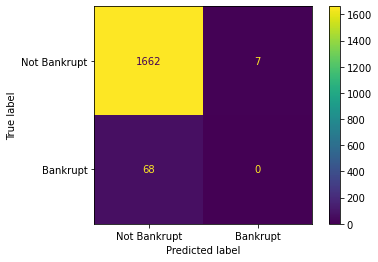

For train...
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      5005
           1       1.00      0.08      0.15       203

    accuracy                           0.96      5208
   macro avg       0.98      0.54      0.57      5208
weighted avg       0.97      0.96      0.95      5208



KNeighborsClassifier(n_neighbors=2)

In [20]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2)
build_model(knn,X_train_imp,Y_train,None,None,X_test,Y_test,impute_test=True,imputer=knn_imp)

[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.97      0.96      0.97      1669
           1       0.24      0.28      0.26        68

    accuracy                           0.94      1737
   macro avg       0.60      0.62      0.61      1737
weighted avg       0.94      0.94      0.94      1737



<Figure size 432x288 with 0 Axes>

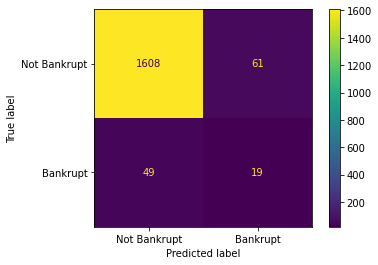

For train...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5005
           1       1.00      1.00      1.00       203

    accuracy                           1.00      5208
   macro avg       1.00      1.00      1.00      5208
weighted avg       1.00      1.00      1.00      5208



DecisionTreeClassifier()

In [21]:
# DecTrees
from sklearn.tree import DecisionTreeClassifier
decTree = DecisionTreeClassifier()
build_model(decTree,X_train_imp,Y_train,None,None,X_test,Y_test,impute_test=True,imputer=knn_imp)

In [22]:
# from sklearn.tree import plot_tree
# plot_tree(decTree) 

[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      1669
           1       0.39      0.10      0.16        68

    accuracy                           0.96      1737
   macro avg       0.68      0.55      0.57      1737
weighted avg       0.94      0.96      0.95      1737



<Figure size 432x288 with 0 Axes>

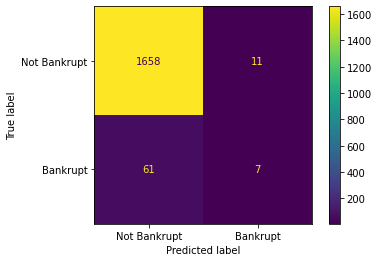

For train...
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      5005
           1       0.81      0.14      0.24       203

    accuracy                           0.97      5208
   macro avg       0.89      0.57      0.61      5208
weighted avg       0.96      0.97      0.95      5208



AdaBoostClassifier()

In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

ada = AdaBoostClassifier()
build_model(ada,X_train_imp,Y_train,None,None,X_test,Y_test,impute_test=True,imputer=knn_imp)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:15:13] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1669
           1       0.74      0.34      0.46        68

    accuracy                           0.97      1737
   macro avg       0.86      0.67      0.72      1737
weighted avg       0.96      0.97      0.96      1737



<Figure size 432x288 with 0 Axes>

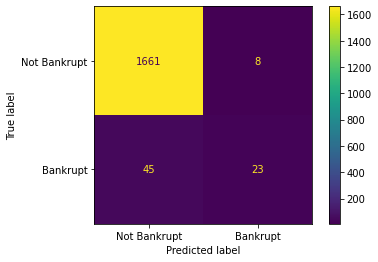

For train...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5005
           1       1.00      1.00      1.00       203

    accuracy                           1.00      5208
   macro avg       1.00      1.00      1.00      5208
weighted avg       1.00      1.00      1.00      5208



In [24]:
from xgboost import XGBClassifier

xgb = XGBClassifier(scale_pos_weight=16)
xgb = build_model(xgb,X_train_imp,Y_train,None,None,X_test,Y_test,impute_test=True,imputer=knn_imp)



[13:15:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[IterativeImputer] Completing matrix with shape (1737, 62)
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1669
           1       0.74      0.34      0.46        68

    accuracy                           0.97      1737
   macro avg       0.86      0.67      0.72      1737
weighted avg       0.96      0.97      0.96      1737



<Figure size 432x288 with 0 Axes>

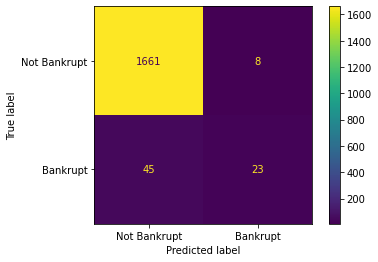

For train...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5005
           1       1.00      1.00      1.00       203

    accuracy                           1.00      5208
   macro avg       1.00      1.00      1.00      5208
weighted avg       1.00      1.00      1.00      5208



In [25]:
## GOOD VALUE: KNN impute with tol 0.01 and maxiter 32 => f1=46%

from xgboost import XGBClassifier

xgb = XGBClassifier(scale_pos_weight=16)
xgb = build_model(xgb,X_train_imp,Y_train,None,None,X_test,Y_test,impute_test=True,imputer=knn_imp)


In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30)
pca = pca.fit(X_train_imp)

In [27]:
X_train_imp_pca = pca.transform(X_train_imp)

[IterativeImputer] Completing matrix with shape (1737, 62)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1669
           1       0.22      0.03      0.05        68

    accuracy                           0.96      1737
   macro avg       0.59      0.51      0.52      1737
weighted avg       0.93      0.96      0.94      1737



<Figure size 432x288 with 0 Axes>

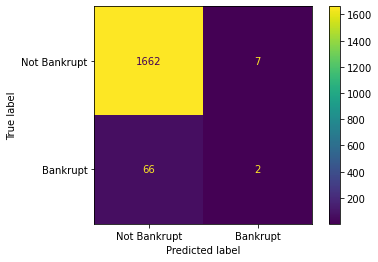

For train...
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5005
           1       1.00      1.00      1.00       203

    accuracy                           1.00      5208
   macro avg       1.00      1.00      1.00      5208
weighted avg       1.00      1.00      1.00      5208



In [29]:
from xgboost import XGBClassifier

xgb = XGBClassifier(scale_pos_weight=16)
xgb = build_model(xgb,X_train_imp_pca,Y_train,None,None,pca.transform(knn_imp.transform(X_test)),Y_test,impute_test=False)

